# Initialization

In [161]:
%reload_ext autoreload
%autoreload 2

import os, sys, shutil
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import tqdm
import corner
from nose import tools

import matplotlib as mpl
import matplotlib.pyplot as plt

import kdes

## Normalization

In [115]:
NUM = int(100)
%timeit draw_invert(NUM)
%timeit draw_median(NUM)

584 µs ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
50.6 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<class 'kdes.kernels.Triweight'>
	0.50 : 1.0000e+00
	1.00 : 1.0000e+00
	2.00 : 1.0000e+00
	4.00 : 1.0000e+00
<class 'kdes.kernels.Gaussian'>
	0.50 : 1.0000e+00
	1.00 : 1.0000e+00
	2.00 : 1.0000e+00
	4.00 : 1.0000e+00
<class 'kdes.kernels.Box'>
	0.50 : 1.0003e+00
	1.00 : 9.9366e-01
	2.00 : 9.9700e-01
	4.00 : 9.9867e-01
<class 'kdes.kernels.Parabola'>
	0.50 : 1.0001e+00
	1.00 : 9.9996e-01
	2.00 : 9.9999e-01
	4.00 : 1.0000e+00


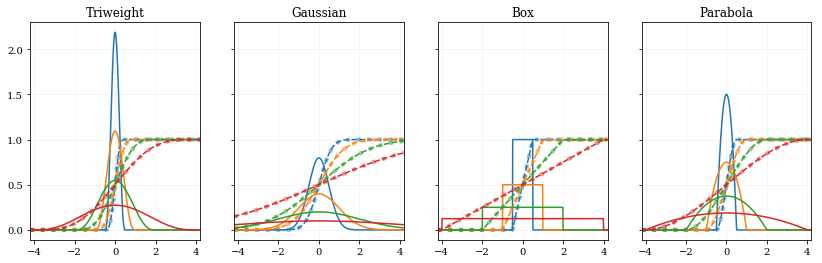

In [140]:
kernels = kdes.kernels._get_all_kernels()
num = len(kernels)

fig, axes = plt.subplots(figsize=[14, 4], ncols=num, sharey=True, sharex=True)
for ax in axes:
    ax.grid(alpha=0.15)

xe = np.linspace(-20.0, 20.0, 3000)
xc = kdes.utils.midpoints(xe, 'lin')
dx = np.diff(xe)
ax.set_xlim([-4.2, 4.2])

for ax, kern in zip(axes, kernels):
    print(kern)
    ax.set_title(kern.__name__)
    for bw in [0.5, 1.0, 2.0, 4.0]:
        pdf = kern.evaluate(xc, 0.0, bw=bw)
        tot = np.sum(pdf * dx)
        print("\t{:.2f} : {:.4e}".format(bw, tot))
        l1, = ax.plot(xc, pdf)
        ax.plot(xc, np.cumsum(pdf*dx), ls='--', color=l1.get_color())
        ax.plot(xc, kern.cdf(xc, bw=bw), ls=':', color=l1.get_color(), lw=4.0, alpha=0.5)
        tools.assert_almost_equal(tot, 1.0, delta=1e-2)
    
plt.show()

## Resampling

Kernel: Box, bw: 5.00e-01 :: pdf : x2/dof = 2.3098e-03
	[9.83e-01, 1.01e+00, 1.03e+00 ... 9.87e-01, 1.10e+00, 9.46e-01]
	[1.00e+00, 1.00e+00, 1.00e+00 ... 1.00e+00, 1.00e+00, 1.00e+00]
Kernel: Box, bw: 5.00e-01 :: cdf : x2/dof = 2.7117e-04
	[1.18e-02, 6.22e-02, 1.14e-01 ... 1.00e+00, 1.00e+00, 1.00e+00]
	[1.28e-02, 6.41e-02, 1.15e-01 ... 1.00e+00, 1.00e+00, 1.00e+00]
Kernel: Box, bw: 2.00e+00 :: pdf : x2/dof = 1.6098e-03
	[2.42e-01, 2.37e-01, 2.54e-01 ... 2.34e-01, 2.56e-01, 2.63e-01]
	[2.50e-01, 2.50e-01, 2.50e-01 ... 2.50e-01, 2.50e-01, 2.50e-01]
Kernel: Box, bw: 2.00e+00 :: cdf : x2/dof = 1.6959e-04
	[1.33e-02, 6.29e-02, 1.12e-01 ... 1.00e+00, 1.00e+00, 1.00e+00]
	[1.28e-02, 6.41e-02, 1.15e-01 ... 1.00e+00, 1.00e+00, 1.00e+00]
Kernel: Parabola, bw: 5.00e-01 :: pdf : x2/dof = 2.1319e-03
	[2.36e-01, 5.05e-01, 7.18e-01 ... 7.27e-01, 5.21e-01, 2.20e-01]
	[2.22e-01, 4.90e-01, 7.27e-01 ... 7.27e-01, 4.90e-01, 2.22e-01]
Kernel: Parabola, bw: 5.00e-01 :: cdf : x2/dof = 1.2185e-02
	[2.00e-04

AssertionError: False is not true

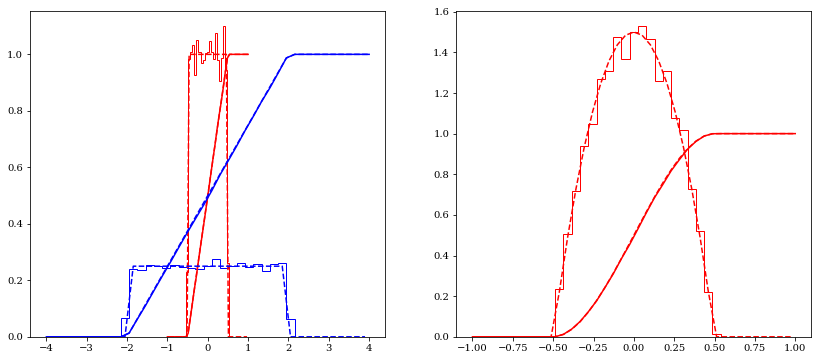

In [303]:
def kernel_bandwidth(ax, kern, bw, color):
    NUM = int(1e4)
    xe, xc, dx = kdes.utils.bins(-2*bw, 2*bw, 40)
    samp = kern.sample(1, bw, NUM).squeeze()
    
    hist, _ = np.histogram(samp, xe, density=True)
    pdf = kern.evaluate(xc, 0.0, bw)

    hist_cum = np.cumsum(hist*dx)
    hist_cum = np.append([0.0], hist_cum)
    cdf = kern.cdf(xe, bw=bw)
    
    ax.hist(samp, xe, histtype='step', color=color, density=True)
    ax.plot(xc, pdf, color=color, ls='--')
    
    ax.plot(xe, hist_cum, color=color, ls='-')
    ax.plot(xe, cdf, color=color, ls='--')
    
    for aa, bb, name in zip([hist, hist_cum], [pdf, cdf], ['pdf', 'cdf']):
        idx = (aa > 0.0) & (bb > 0.0)
        dof = np.count_nonzero(idx) - 1
        x2 = np.sum(np.square(aa[idx] - bb[idx])/bb[idx]**2)
        x2 = x2 / dof        
        print("Kernel: {}, bw: {:.2e} :: {} : x2/dof = {:.4e}".format(kern.__name__, bw, name, x2))
        print("\t" + kdes.utils.array_str(aa[idx]))
        print("\t" + kdes.utils.array_str(bb[idx]))
        tools.assert_true(x2 < 1e-2)
        
    return


bandwidths = [0.5, 2.0]  #, 2.0]
colors = ['r', 'b']  # , 'g']

kernels = ['box', 'parabola']
fig, axes = plt.subplots(figsize=[14, 6], ncols=len(kernels))
    
for ii, ax in enumerate(axes):
    kern = kernels[ii]
    kern = kdes.kernels.get_kernel_class(kern)
    
    for jj, bw in enumerate(bandwidths):
        cc = colors[jj]
        kernel_bandwidth(ax, kern, bw, cc)

plt.show()

# Particular Kernels

## Epanechnikov (Parabola)

### Show that the median method is the same as CDF inversion 

In [ ]:
def draw_invert(size):
    xe, xc, dx = kdes.utils.bins(-1.0, 1.0, 1000)
    yy = kdes.kernels.Parabola.evaluate(xc)
    cs = np.cumsum(yy*dx)
    
    xc = np.concatenate([[-1.0], xc, [1.0]])
    cs = np.concatenate([[0.0], cs, [1.0]])
    
    xx = sp.interpolate.interp1d(cs, xc, kind='cubic')(np.random.uniform(0.0, 1.0, size))
    return xx

def draw_median(size):
    xx = np.random.uniform(-1, 1, 3*size).reshape(3, size)
    xx = np.median(xx, axis=0)
    return xx
    

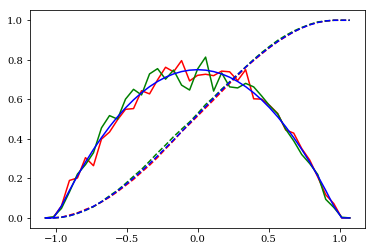

In [121]:
NUM = int(1e4)

aa = draw_median(NUM)
edges, cents, wids = kdes.utils.bins(-1.1, 1.1, 40)

hist, _ = np.histogram(aa, edges, density=True)
cum_hist = np.cumsum(hist*wids)
pdf = kdes.kernels.Parabola.evaluate(cents)
cum_pdf = np.cumsum(pdf*wids)

test = draw(NUM)
hist_test, _ = np.histogram(test, edges, density=True)
cum_test = np.cumsum(hist_test*wids)

plt.plot(cents, hist, 'r-')
plt.plot(cents, cum_hist, 'r--')

plt.plot(cents, hist_test, 'g-')
plt.plot(cents, cum_test, 'g--')

plt.plot(cents, pdf, 'b-')
plt.plot(cents, cum_pdf, 'b--')